In [1]:
import dicom_contour.contour as dcm
import pathlib as Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom as dicom


import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers


/Users/ianbenlolo/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [119]:
rt_sequence = dicom.read_file(image_path+contour_filename)
#print rt_sequence

In [45]:
print dcm.get_roi_names(rt_sequence)
print type(rt_sequence)
print rt_sequence

['Organ', 'GTV']
<class 'pydicom.dataset.FileDataset'>
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0012) Instance Creation Date              DA: '20180612'
(0008, 0013) Instance Creation Time              TM: '114933.919000'
(0008, 0016) SOP Class UID                       UI: RT Structure Set Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.71.4.139189879485.219268.20180611142152
(0008, 0020) Study Date                          DA: '20100512'
(0008, 0030) Study Time                          TM: '151324'
(0008, 0050) Accession Number                    SH: '50413970RVH'
(0008, 0060) Modality                            CS: 'RTSTRUCT'
(0008, 0070) Manufacturer                        LO: 'Varian Medical Systems'
(0008, 0090) Referring Physician's Name          PN: 'TREMBLAY^F. 85044'
(0008, 1010) Station Name                        SH: 'WNETAP170'
(0008, 1030) Study Description                   LO: 'MRI-BIL BREASTS'
(0008, 103e) Series

In [46]:
def get_roi_contour_ds(rt_sequence, index):
    """
    Extract desired ROI contour datasets
    from RT Sequence.
    
    E.g. rt_sequence can have contours for different parts of the brain 
    such as ventricles, tumor, etc...
    
    You can use get_roi_names to find which index to use
    
    Inputs:
        rt_sequence (dicom.dataset.FileDataset): Contour file dataset, what you get 
                                                 after reading contour DICOM file
        index (int): Index for ROI Sequence
    Return:
        contours (list): list of ROI contour dicom.dataset.Dataset s
    """
    # index 0 means that we are getting RTV information
    ROI = rt_sequence.ROIContourSequence[index]
    # get contour datasets in a list
    contours = [contour for contour in ROI.ContourSequence]
    return contours

In [123]:
contour_datasets = get_roi_contour_ds(rt_sequence=rt_sequence, index=0)

print contour_datasets

[(3006, 0016)  Contour Image Sequence   1 item(s) ---- 
   (0008, 1150) Referenced SOP Class UID            UI: MR Image Storage
   (0008, 1155) Referenced SOP Instance UID         UI: 1.2.840.113619.2.374.10539969.799637.14095.1437998677.84
   ---------
(3006, 0042) Contour Geometric Type              CS: 'CLOSED_PLANAR'
(3006, 0046) Number of Contour Points            IS: '16'
(3006, 0050) Contour Data                        DS: ['-92.62', '-17.06', '-16.72', '-94.11', '-17.17', '-16.72', '-94.26', '-17.31', '-16.72', '-94.4', '-18.79', '-16.72', '-94.11', '-19.2', '-16.72', '-92.89', '-20.28', '-16.72', '-92.62', '-20.46', '-16.72', '-91.57', '-21.76', '-16.72', '-91.14', '-22.7', '-16.72', '-89.65', '-23.05', '-16.72', '-88.57', '-21.76', '-16.72', '-88.71', '-20.28', '-16.72', '-89.65', '-19.68', '-16.72', '-90.73', '-18.79', '-16.72', '-91.14', '-17.94', '-16.72', '-92.01', '-17.31', '-16.72'], (3006, 0016)  Contour Image Sequence   1 item(s) ---- 
   (0008, 1150) Referenced SOP 

In [48]:
def contour2poly(contour_dataset, path):
    """
    Given a contour dataset (a DICOM class) and path that has .dcm files of
    corresponding images return polygon coordinates for the contours.

    Inputs
        contour_dataset (dicom.dataset.Dataset) : DICOM dataset class that is identified as
                         (3006, 0016)  Contour Image Sequence
        path (str): path of directory containing DICOM images

    Return:
        pixel_coords (list): list of tuples having pixel coordinates
        img_ID (id): DICOM image id which maps input contour dataset
        img_shape (tuple): DICOM image shape - height, width
    """

    contour_coord = contour_dataset.ContourData
    # x, y, z coordinates of the contour in mm
    coord = []
    for i in range(0, len(contour_coord), 3):
        coord.append((contour_coord[i], contour_coord[i + 1], contour_coord[i + 2]))

    # extract the image id corresponding to given countour
    # read that dicom file
    img_ID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
    img = dicom.read_file(path +'MR.'+ img_ID + '.dcm')
    img_arr = img.pixel_array
    img_shape = img_arr.shape
    
    # physical distance between the center of each pixel
    x_spacing, y_spacing = float(img.PixelSpacing[0]), float(img.PixelSpacing[1])

    # this is the center of the upper left voxel
    origin_x, origin_y, _ = img.ImagePositionPatient

    # y, x is how it's mapped
    pixel_coords = [( np.ceil(np.abs((x - origin_x) / x_spacing)), np.abs(np.ceil((origin_y - y) / y_spacing))  ) for x, y, _ in coord]
    
    return pixel_coords, img_ID, img_shape

In [49]:
def poly_to_mask(polygon, width, height):
    from PIL import Image, ImageDraw
    
    """Convert polygon to mask
    :param polygon: list of pairs of x, y coords [(x1, y1), (x2, y2), ...]
     in units of pixels
    :param width: scalar image width
    :param height: scalar image height
    :return: Boolean mask of shape (height, width)
    """

    # http://stackoverflow.com/a/3732128/1410871
    img = Image.new(mode='L', size=(width, height), color=0)
    ImageDraw.Draw(img).polygon(xy=polygon, outline=0, fill=1)
    mask = np.array(img).astype(bool)
    return mask

In [72]:
def get_mask_dict(contour_datasets, path):
    """
    Inputs:
        contour_datasets (list): list of dicom.dataset.Dataset for contours
        path (str): path of directory with images

    Return:
        img_contours_dict (dict): img_id : contour array pairs
    """
    
    from collections import defaultdict
    
    # create empty dict for 
    img_contours_dict = defaultdict(int)

    for cdataset in contour_datasets:
        coords, img_id, shape = contour2poly(cdataset, path)
#        print coords
        mask = poly_to_mask(coords, *shape)
#        print('mask\n\n')
        img_contours_dict[img_id] += mask
    return img_contours_dict

In [73]:
def parse_dicom_file(filename):
    """
    Parse the given DICOM filename
    :param filename: filepath to the DICOM file to parse
    :return: dictionary with DICOM image data
    """

    try:
        dcm = dicom.read_file(filename)
        dcm_image = dcm.pixel_array

        try:
            intercept = dcm.RescaleIntercept
        except AttributeError:
            intercept = 0.0
        try:
            slope = dcm.RescaleSlope
        except AttributeError:
            slope = 0.0

        if intercept != 0.0 and slope != 0.0:
            dcm_image = dcm_image*slope + intercept
        return dcm_image
    except dicom.errors.InvalidDicomError:
        return None

In [74]:
#the dictionary containing the slice -- mask information 
mask_dict = get_mask_dict(contour_datasets, image_path)

#get the orders the slices come in
slice_orders = dcm.slice_order(image_path)




#mask_dict.items()

In [53]:
def contour2poly1(contour_dataset, path):
    """
    Given a contour dataset (a DICOM class) and path that has .dcm files of
    corresponding images return polygon coordinates for the contours.

    Inputs
        contour_dataset (dicom.dataset.Dataset) : DICOM dataset class that is identified as
                         (3006, 0016)  Contour Image Sequence
        path (str): path of directory containing DICOM images

    Return:
        pixel_coords (list): list of tuples having pixel coordinates
        img_ID (id): DICOM image id which maps input contour dataset
        img_shape (tuple): DICOM image shape - height, width
    """

    contour_coord = contour_dataset.ContourData
    # x, y, z coordinates of the contour in mm
    coord = []
    for i in range(0, len(contour_coord), 3):
        coord.append((contour_coord[i], contour_coord[i + 1], contour_coord[i + 2]))

    # extract the image id corresponding to given countour
    # read that dicom file
    img_ID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
    img = dicom.read_file(path +'MR.'+ img_ID + '.dcm')
    img_arr = img.pixel_array
    img_shape = img_arr.shape
    
    # physical distance between the center of each pixel
    x_spacing, y_spacing = float(img.PixelSpacing[0]), float(img.PixelSpacing[1])
#    print('x_spacing',x_spacing)
#    print('y_spacing',y_spacing)
    # this is the center of the upper left voxel
    origin_x, origin_y, _ = img.ImagePositionPatient
#    print('origin_x',origin_x)
#    print('origin_y',origin_y)
    # y, x is how it's mapped
    
    pixel_coords = [( np.abs(np.ceil((x - origin_x) / x_spacing)), np.ceil((origin_y + y) / y_spacing))  for x, y, _ in coord]
#    print coord
#    print pixel_coords
    
    return pixel_coords, img_ID, img_shape
for cdataset in contour_datasets:
        coords, img_id, shape = contour2poly1(cdataset, image_path)
mask = poly_to_mask(coords, *shape)

('x_spacing', 0.5273)
('y_spacing', 0.5273)
('origin_x', "127.928")
('origin_y', "129.818")
[("79.15", "-13.76", "-41.18"), ("78.86", "-13.87", "-41.18"), ("78.1", "-14.12", "-41.18"), ("77.04", "-14.09", "-41.18"), ("75.99", "-14.76", "-41.18"), ("75.73", "-14.93", "-41.18"), ("74.93", "-15.55", "-41.18"), ("74.64", "-15.98", "-41.18"), ("73.94", "-17.04", "-41.18"), ("73.88", "-17.17", "-41.18"), ("73.57", "-18.09", "-41.18"), ("73.51", "-19.14", "-41.18"), ("73.63", "-20.2", "-41.18"), ("73.88", "-20.71", "-41.18"), ("74.15", "-21.25", "-41.18"), ("74.93", "-22.23", "-41.18"), ("75.01", "-22.31", "-41.18"), ("75.37", "-23.36", "-41.18"), ("75.52", "-24.42", "-41.18"), ("75.67", "-25.47", "-41.18"), ("75.7", "-26.53", "-41.18"), ("75.88", "-27.58", "-41.18"), ("75.99", "-27.84", "-41.18"), ("76.27", "-28.64", "-41.18"), ("77", "-29.69", "-41.18"), ("77.04", "-29.73", "-41.18"), ("78.1", "-30.41", "-41.18"), ("78.9", "-30.74", "-41.18"), ("79.15", "-30.87", "-41.18"), ("80.21", "-31.1

In [54]:
print coords
print img_id
print shape
help(np.abs)


[(84.0, 213.0), (86.0, 214.0), (88.0, 214.0), (90.0, 214.0), (92.0, 214.0), (94.0, 214.0), (96.0, 212.0), (96.0, 212.0), (98.0, 211.0), (98.0, 210.0), (99.0, 208.0), (100.0, 207.0), (100.0, 206.0), (101.0, 204.0), (100.0, 203.0), (100.0, 202.0), (100.0, 200.0), (100.0, 199.0), (100.0, 198.0), (101.0, 196.0), (101.0, 194.0), (100.0, 192.0), (100.0, 192.0), (99.0, 190.0), (98.0, 190.0), (96.0, 189.0), (95.0, 188.0), (94.0, 188.0), (92.0, 187.0), (91.0, 186.0), (90.0, 186.0), (88.0, 186.0), (88.0, 186.0), (86.0, 187.0), (85.0, 188.0), (84.0, 190.0), (84.0, 190.0), (82.0, 192.0), (82.0, 193.0), (81.0, 194.0), (80.0, 196.0), (80.0, 196.0), (78.0, 198.0), (77.0, 198.0), (76.0, 200.0), (76.0, 202.0), (77.0, 204.0), (77.0, 206.0), (78.0, 208.0), (78.0, 208.0), (80.0, 210.0), (80.0, 211.0), (82.0, 212.0), (82.0, 212.0)]
1.2.840.113619.2.176.3596.12393670.6994.1273663310.607
(512, 512)
Help on ufunc object:

absolute = class ufunc(__builtin__.object)
 |  Functions that operate element by element

In [55]:
def get_img_mask_voxel(slice_orders, mask_dict, image_path):
    """ 
    Construct image and mask voxels
    
    Inputs:
        slice_orders (list): list of tuples of ordered img_id and z-coordinate position
        mask_dict (dict): dictionary having img_id : contour array pairs
        image_path (str): directory path containing DICOM image files
    Return: 
        img_voxel: ordered image voxel for CT/MR
        mask_voxel: ordered mask voxel for CT/MR
    """
    
    img_voxel = []
    mask_voxel = []
    for img_id, _ in slice_orders:
        img_array = parse_dicom_file(image_path + 'MR.'+img_id + '.dcm')
        if img_id in mask_dict: mask_array = mask_dict[img_id]
        else: mask_array = np.zeros_like(img_array)
        img_voxel.append(img_array)
        mask_voxel.append(mask_array)
    return img_voxel, mask_voxel

In [56]:
img_data, mask_data = get_img_mask_voxel(slice_orders, mask_dict, image_path)

In [132]:
def get_data(image_path, contour_filename, roi_index):
    """
    Given image_path, contour_filename and roi_index return
    image and mask voxel array
    
    Inputs:
        image_path (str): directory path containing DICOM image files
        contour_filename (str): absolute filename for DICOM contour file
        roi_index (int): index for desired ROI from RT Struct
    Return:
        img_voxel (np.array): 3 dimensional numpy array of ordered images
        mask_voxel (np.array): 3 dimensional numpy array of ordered masks
    """
    # read dataset for contour
    rt_sequence = dicom.read_file(image_path+contour_filename)

    # get contour datasets with index idx
    contour_datasets = get_roi_contour_ds(rt_sequence, roi_index)
#    print contour_datasets
    
    # construct mask dictionary
    mask_dict = get_mask_dict(contour_datasets, image_path)
#    print '\n\n\n\n\n MASK DICT'
#    print mask_dict
    
    # get slice orders
    slice_orders = dcm.slice_order(image_path)
    
#    print '\n\n\n\nSLICE ORDERS'
#    print slice_orders
    # get image and mask data for patient
    img_voxel, mask_voxel = get_img_mask_voxel(slice_orders, mask_dict, image_path)
    return img_voxel, mask_voxel

def show_img_msk_fromarray(img_arr, msk_arr, alpha=0.35, sz=7, cmap='inferno',
                           save_path=None):

    """
    Show original image and masked on top of image
    next to each other in desired size
    Inputs:
        img_arr (np.array): array of the image
        msk_arr (np.array): array of the mask
        alpha (float): a number between 0 and 1 for mask transparency
        sz (int): figure size for display
        save_path (str): path to save the figure
    """

    msk_arr = np.ma.masked_where(msk_arr == 0, msk_arr)
    plt.figure(figsize=(sz, sz))
    plt.subplot(1, 2, 1)
    plt.imshow(img_arr, cmap='gray')
    plt.imshow(msk_arr, cmap=cmap, alpha=alpha)

    plt.subplot(1, 2, 2)
    plt.imshow(img_arr, cmap='gray')
    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close()

In [134]:
contour_data = dicom.read_file(image_path+contour_filename)

print dcm.get_roi_names(contour_data)
img_voxel, mask_voxel = get_data(image_path, contour_filename, roi_index=1)

['Organ', 'GTV']


In [105]:
#for img, mask in zip(img_voxel, mask_voxel):
#    show_img_msk_fromarray(img, mask, sz=10, cmap='inferno', alpha=1)

for i in range(0,len(mask_voxel)):
    temp = 0
    for c in mask_voxel[i]:
        temp += np.count_nonzero(c)
#    print temp


<type 'numpy.ndarray'>


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

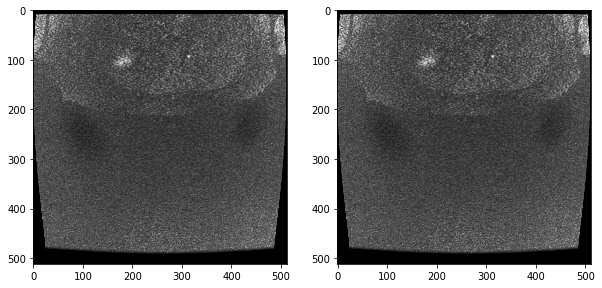

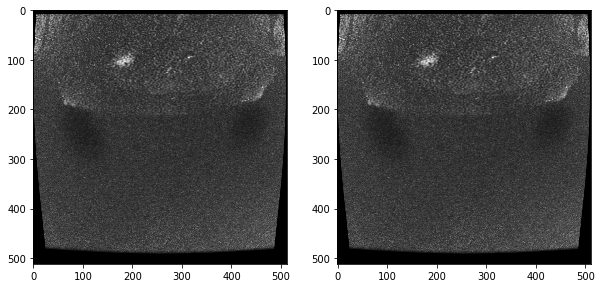

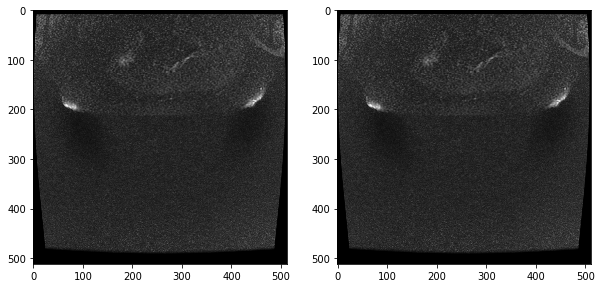

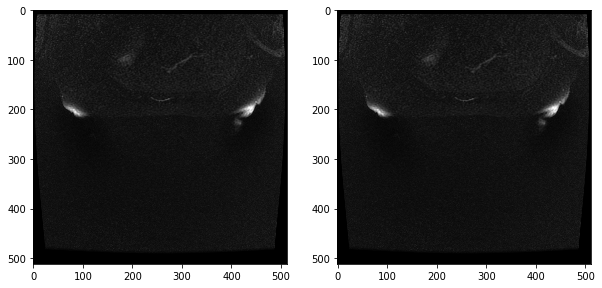

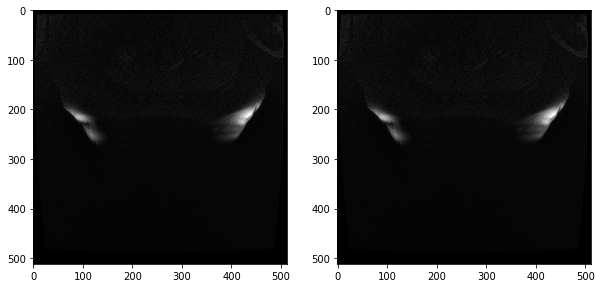

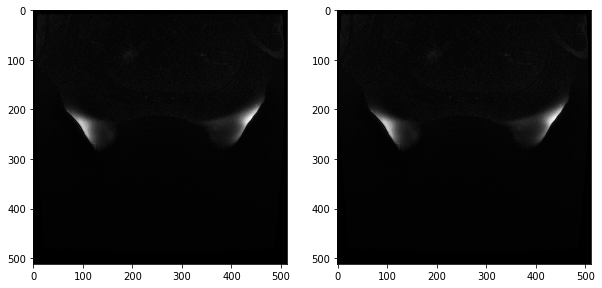

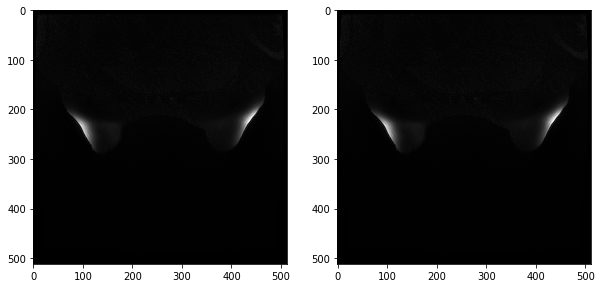

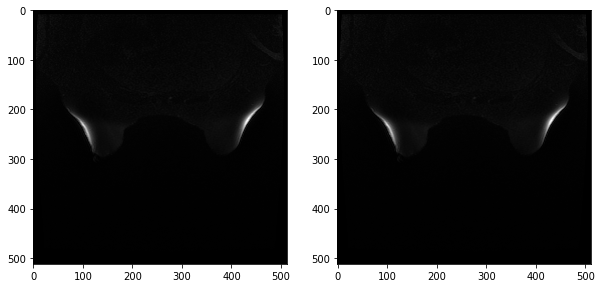

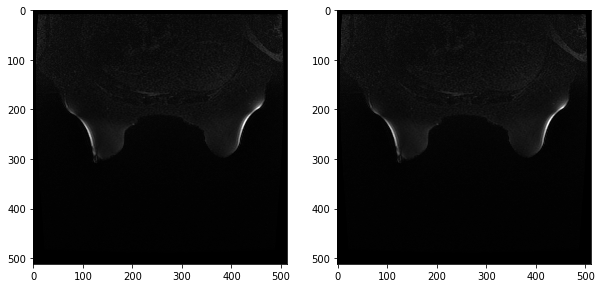

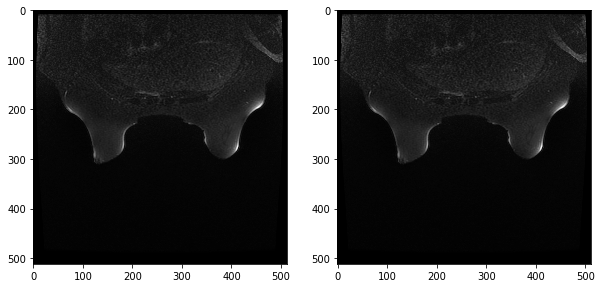

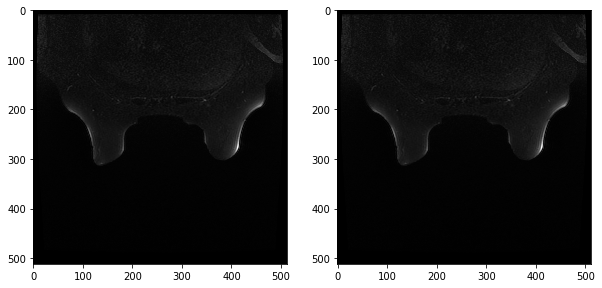

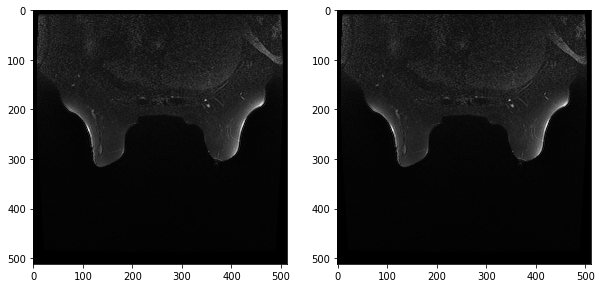

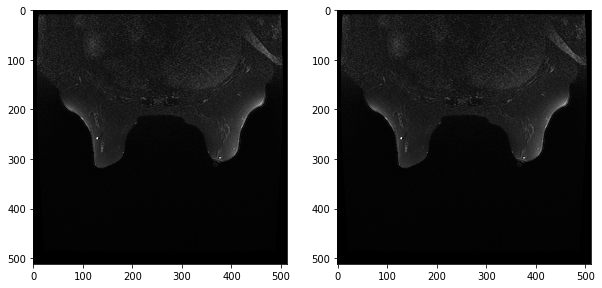

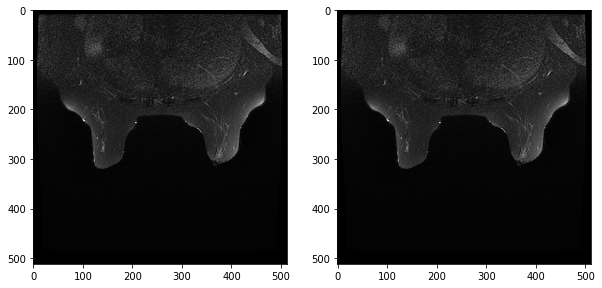

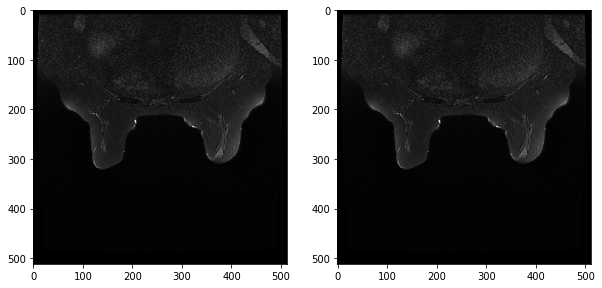

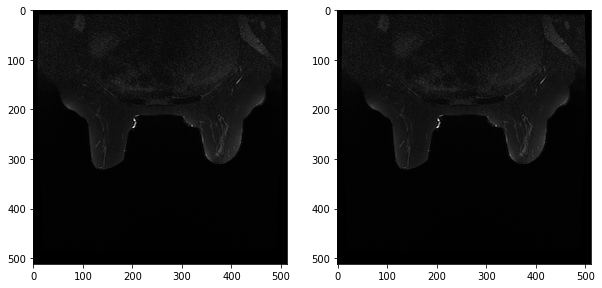

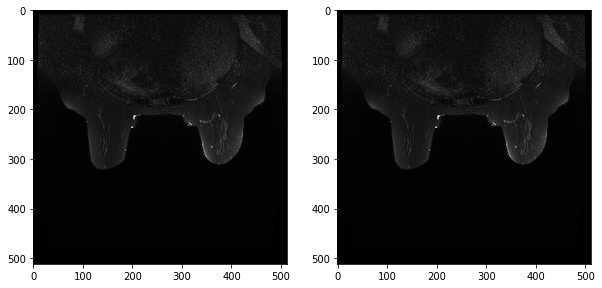

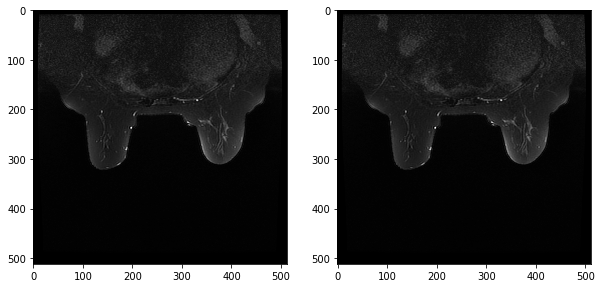

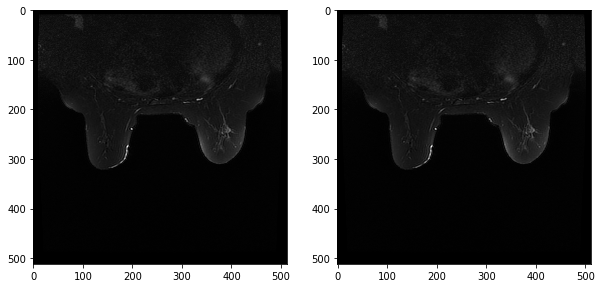

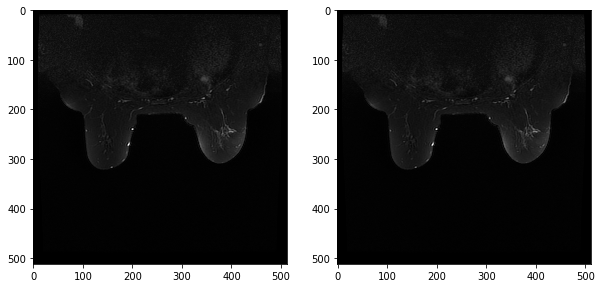

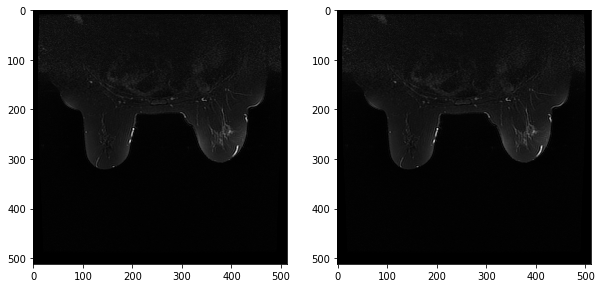

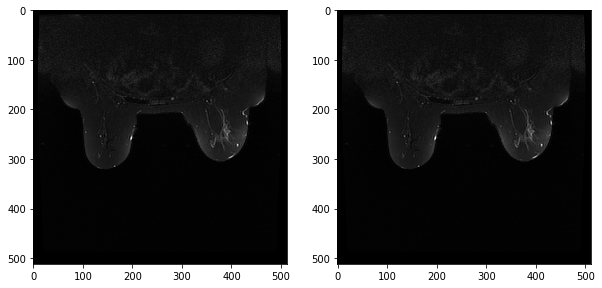

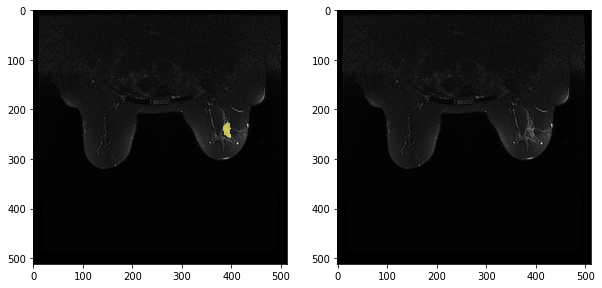

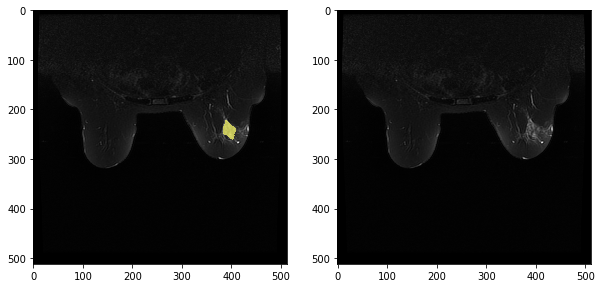

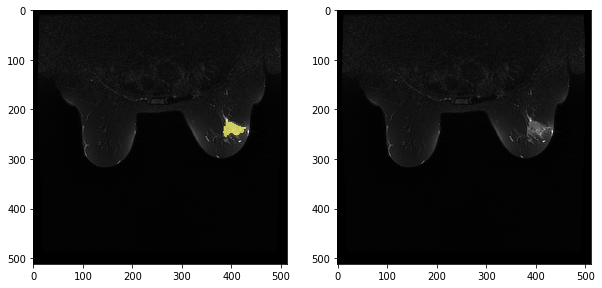

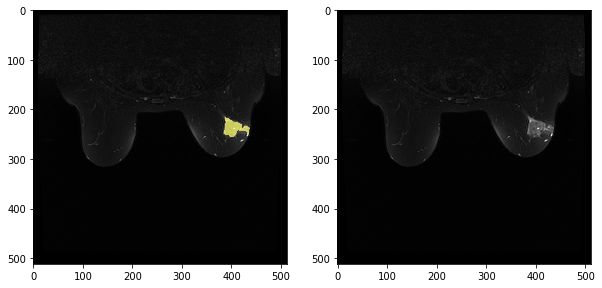

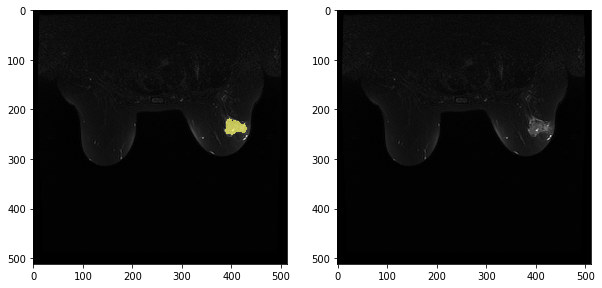

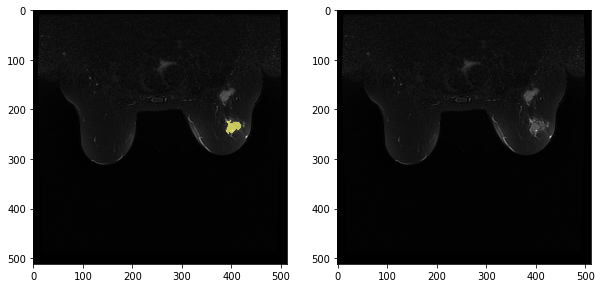

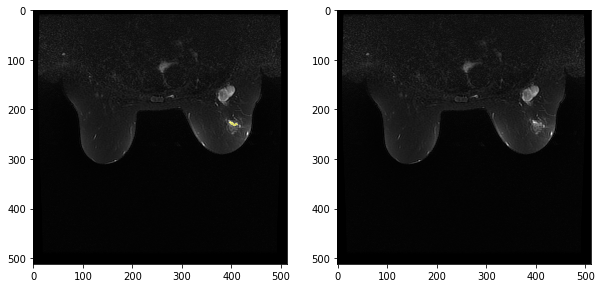

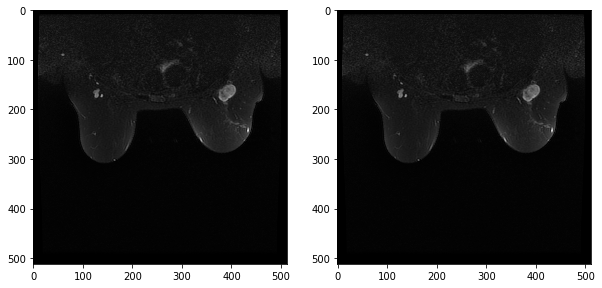

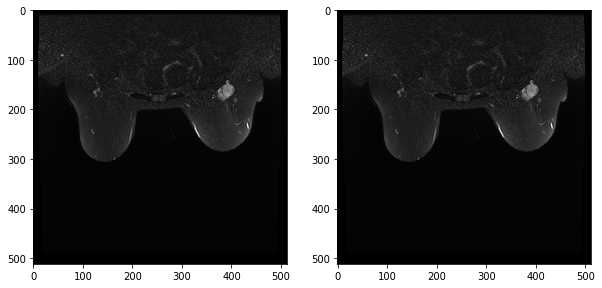

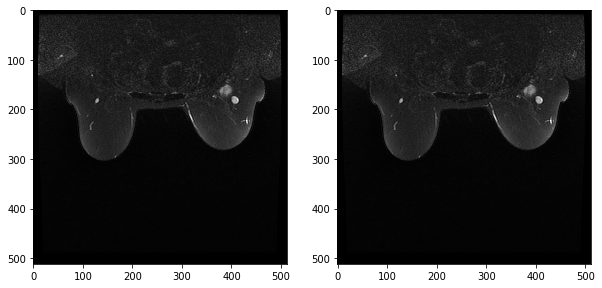

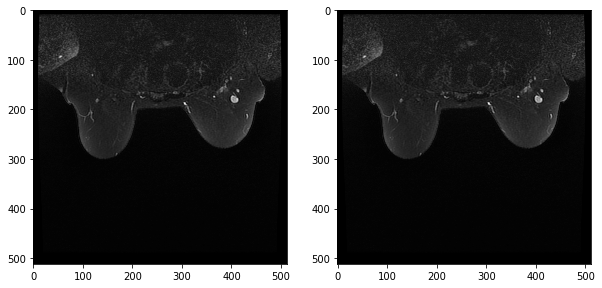

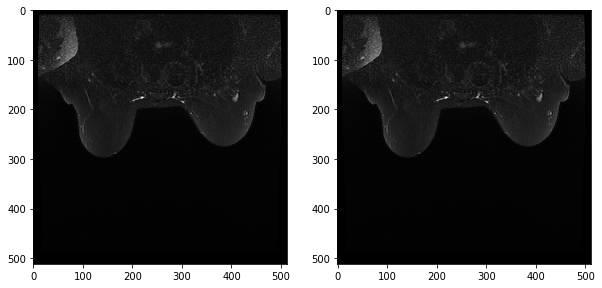

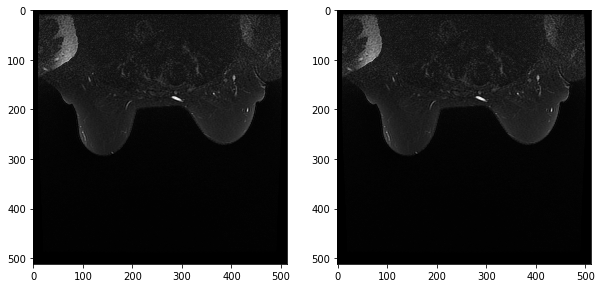

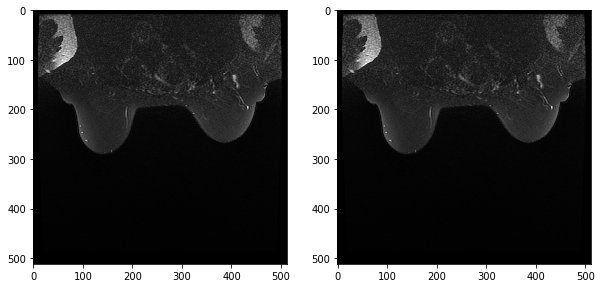

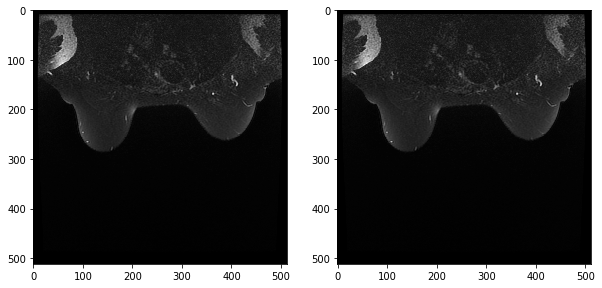

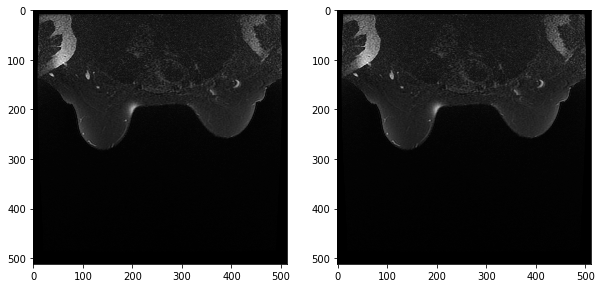

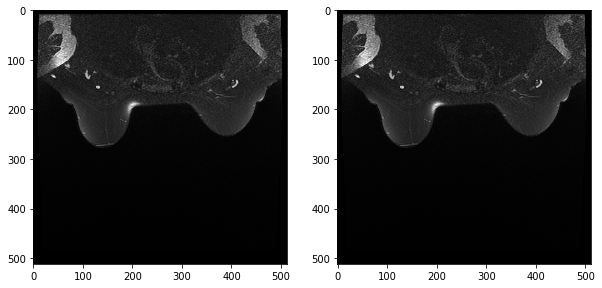

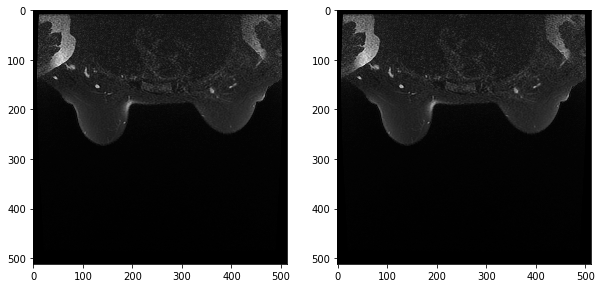

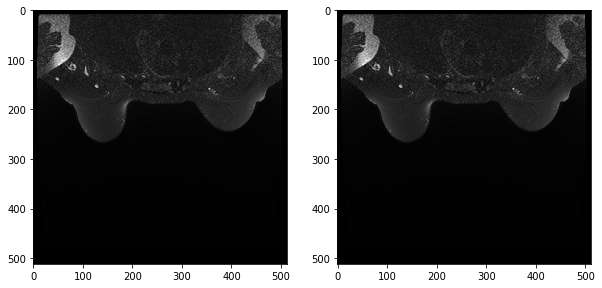

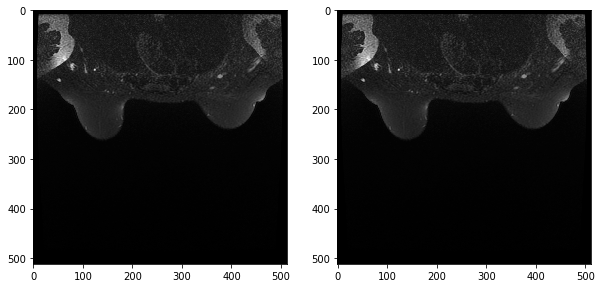

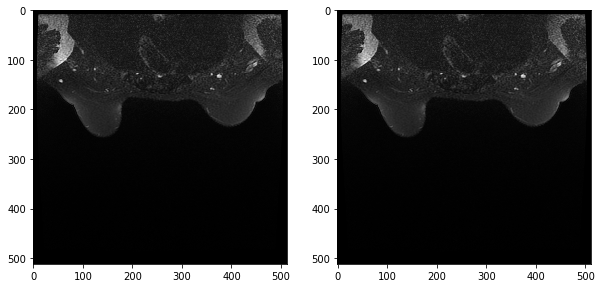

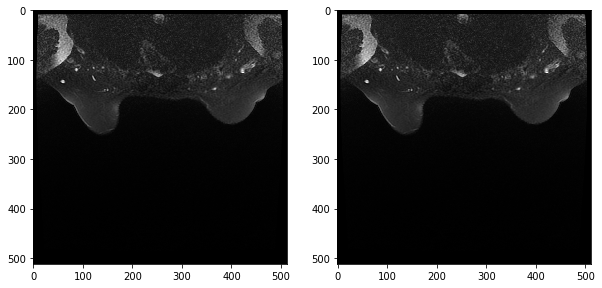

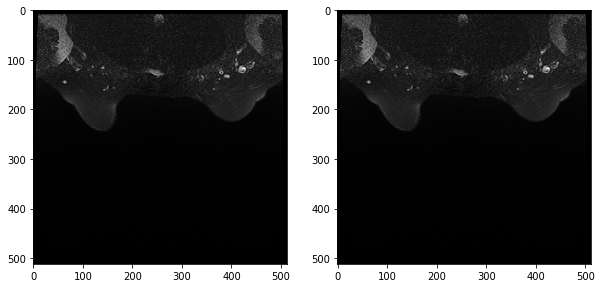

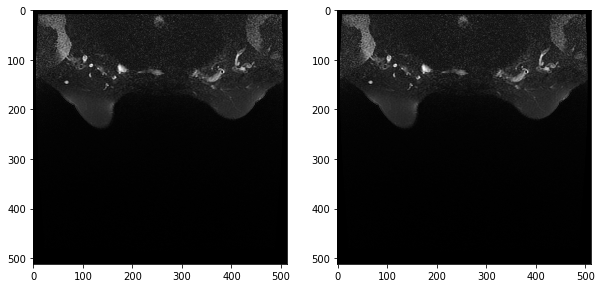

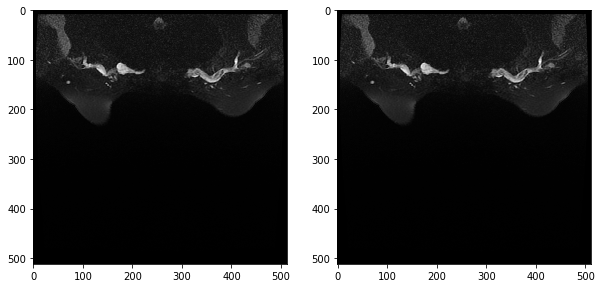

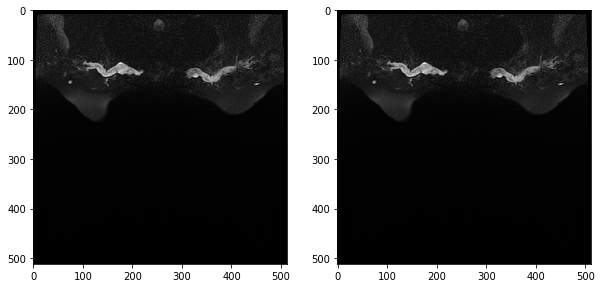

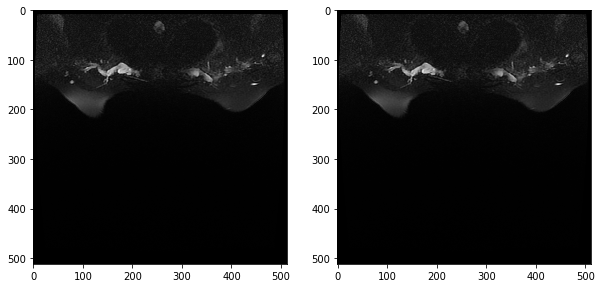

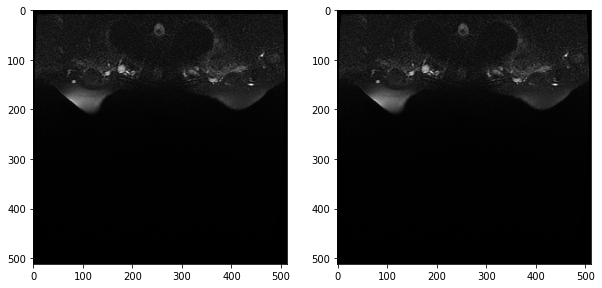

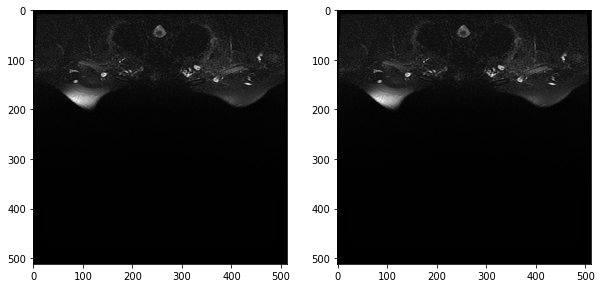

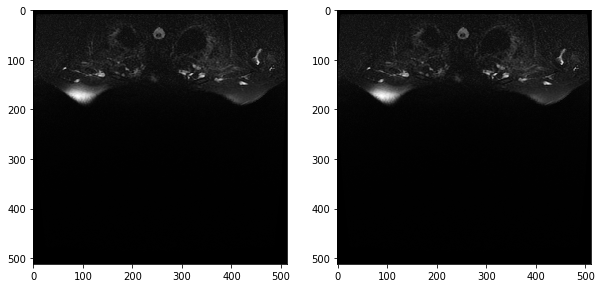

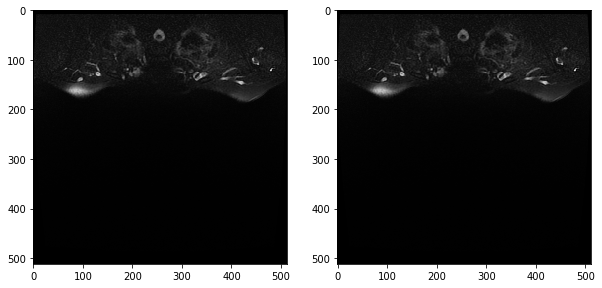

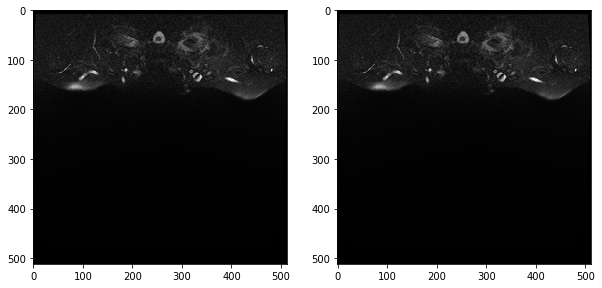

In [135]:
image_path = './Breast_MRI_cont/Belec/'
contour_filename = 'RS.1.2.246.352.71.4.139189879485.219269.20180611142708.dcm'

img_voxel, mask_voxel = get_data(image_path, contour_filename, roi_index=1)
for img, mask in zip(img_voxel, mask_voxel):
    show_img_msk_fromarray(img, mask, sz=10, cmap='summer_r', alpha=0.7)

## Create a simple model

Ill start with a simple one: one convolution, one average pooling and one fully connected layer. Well see where we go from there

In [ ]:
def model(shape = (512,512)): # should i reshape to 64x64? 
    
    model = Sequential()
    
    model.add(Conv2D(100, (22,22), padding='valid', strides=(1, 1), input_shape=(input_shape[0], input_shape[1], 1)))
    model.add(AveragePooling2D((6,6)))
    
    model.add(Reshape([-1, 8100]))
    
    model.add(Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Reshape([-1, 32, 32]))
    return model

In [102]:
help(np.ma.masked_where)

Help on function masked_where in module numpy.ma.core:

masked_where(condition, a, copy=True)
    Mask an array where a condition is met.
    
    Return `a` as an array masked where `condition` is True.
    Any masked values of `a` or `condition` are also masked in the output.
    
    Parameters
    ----------
    condition : array_like
        Masking condition.  When `condition` tests floating point values for
        equality, consider using ``masked_values`` instead.
    a : array_like
        Array to mask.
    copy : bool
        If True (default) make a copy of `a` in the result.  If False modify
        `a` in place and return a view.
    
    Returns
    -------
    result : MaskedArray
        The result of masking `a` where `condition` is True.
    
    See Also
    --------
    masked_values : Mask using floating point equality.
    masked_equal : Mask where equal to a given value.
    masked_not_equal : Mask where `not` equal to a given value.
    masked_less_equal : Mas